# SVM Model for NewDataset Sarborno
Running SVM classification on the newly cleaned sarborno dataset

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 640.0 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.8 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 537.5 kB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
    --------------------------------------- 0.1/8.9 MB 6.4 MB/s eta 0:00:02
   - -------------------------------------- 0.3/8.9 MB 3.8 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.9 MB 4.1 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/8.9 MB 5.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/8.9 MB 6.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.1/8.9 MB 7.8 MB/s eta 0:00:01
   --------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Load and Prepare NewDataset Sarborno for SVM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("🎯 LOADING NEWDATASET SARBORNO FOR SVM ANALYSIS")
print("=" * 60)

# Load the NewDataset sarborno cleaned combined dataset
# Use a Windows-friendly path (relative to workspace root)
file_path = r'NewDataset_sarborno_cleaned_combined.csv'

try:
    sarborno_df = pd.read_csv(file_path)
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {sarborno_df.shape}")
    print(f"📋 Columns: {sarborno_df.columns.tolist()}")
    
    # Basic dataset information
    print(f"\n📈 DATASET OVERVIEW:")
    print(f"   • Total samples: {len(sarborno_df):,}")
    print(f"   • Total features: {len(sarborno_df.columns)}")
    print(f"   • Missing values: {sarborno_df.isnull().sum().sum()}")
    
    # Check label distribution
    if 'label' in sarborno_df.columns:
        print(f"\n🏷️  LABEL DISTRIBUTION:")
        label_counts = sarborno_df['label'].value_counts().sort_index()
        for label, count in label_counts.items():
            print(f"   • {label}: {count:,} samples")
        print(f"   • Total unique labels: {sarborno_df['label'].nunique()}")
    
    # Display first few rows
    print(f"\n📋 SAMPLE DATA:")
    print(sarborno_df.head())
    
except FileNotFoundError:
    print(f"❌ File not found: {file_path}")
    print("Please make sure the NewDataset sarborno file exists in the workspace root.")
except Exception as e:
    print(f"❌ Error loading dataset: {str(e)}")

🎯 LOADING NEWDATASET SARBORNO FOR SVM ANALYSIS
✅ Dataset loaded successfully!
📊 Dataset shape: (6528, 11)
📋 Columns: ['label', 'p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']

📈 DATASET OVERVIEW:
   • Total samples: 6,528
   • Total features: 11
   • Missing values: 0

🏷️  LABEL DISTRIBUTION:
   •  : 1,114 samples
   • |: 1,094 samples
   • অ: 597 samples
   • আ: 343 samples
   • ই: 487 samples
   • উ: 416 samples
   • ঋ: 427 samples
   • এ: 512 samples
   • ঐ: 527 samples
   • ও: 509 samples
   • ঔ: 502 samples
   • Total unique labels: 11

📋 SAMPLE DATA:
  label    p1    p2    p3    p4    p5     r1     r2    r3     r4     r5
0     অ -2.48 -6.39  1.10 -3.82 -7.33 -88.17 -21.17 -1.14  12.70  16.72
1     অ -0.86 -6.99  0.33 -4.44 -7.68 -88.85 -20.75 -0.59  13.31  16.48
2     অ -0.82 -7.64  0.34 -4.28 -7.57 -88.38 -20.95 -0.99  13.02  16.20
3     অ -0.48 -6.83  0.80 -3.75 -7.10 -87.37 -19.36  0.68  14.26  17.29
4     অ -0.69 -6.89  0.65 -4.21 -7.26 -86.80 -18.96  1.17  14.40 

In [3]:
# Data Preprocessing for NewDataset Sarborno
if 'sarborno_df' in locals() and not sarborno_df.empty:
    print("\n🔧 DATA PREPROCESSING FOR NEWDATASET SARBORNO")
    print("=" * 50)
    
    # Create a copy for processing
    df_sarborno = sarborno_df.copy()
    
    # Identify feature columns (assuming p1-p5, r1-r5 are the sensor features)
    feature_cols = ['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']
    
    # Check which feature columns exist
    existing_features = [col for col in feature_cols if col in df_sarborno.columns]
    print(f"📊 Available feature columns: {existing_features}")
    
    if len(existing_features) < 5:
        print("⚠️ Warning: Less than 5 feature columns found. Checking for alternative column names...")
        # Look for any numeric columns that might be features
        numeric_cols = df_sarborno.select_dtypes(include=[np.number]).columns.tolist()
        if 'label' in numeric_cols:
            numeric_cols.remove('label')
        print(f"📊 Available numeric columns: {numeric_cols}")
        existing_features = numeric_cols[:10] if len(numeric_cols) >= 10 else numeric_cols
    
    print(f"✅ Using {len(existing_features)} features: {existing_features}")
    
    # Data quality check
    print(f"\n🔍 DATA QUALITY CHECK:")
    print(f"   • Dataset shape: {df_sarborno.shape}")
    print(f"   • Missing values per column:")
    for col in existing_features + ['label']:
        if col in df_sarborno.columns:
            missing = df_sarborno[col].isnull().sum()
            print(f"     - {col}: {missing} ({(missing/len(df_sarborno)*100):.1f}%)")
    
    # Remove rows with missing values in features or label
    initial_shape = df_sarborno.shape
    df_sarborno = df_sarborno.dropna(subset=existing_features + ['label'])
    final_shape = df_sarborno.shape
    
    if initial_shape[0] != final_shape[0]:
        print(f"   • Removed {initial_shape[0] - final_shape[0]} rows with missing values")
        print(f"   • Final dataset shape: {final_shape}")
    
    # Prepare features and target
    X_sarborno = df_sarborno[existing_features]
    y_sarborno = df_sarborno['label']
    
    print(f"\n✅ Feature matrix shape: {X_sarborno.shape}")
    print(f"✅ Target vector shape: {y_sarborno.shape}")
    
    # Check data types
    print(f"\n📋 DATA TYPES:")
    for col in existing_features:
        print(f"   • {col}: {X_sarborno[col].dtype}")
    
    # Ensure all features are numeric
    for col in existing_features:
        if X_sarborno[col].dtype == 'object':
            print(f"⚠️ Converting {col} to numeric...")
            X_sarborno[col] = pd.to_numeric(X_sarborno[col], errors='coerce')
    
    # Fill any remaining NaN values with median
    if X_sarborno.isnull().any().any():
        print("⚠️ Filling remaining NaN values with median...")
        X_sarborno = X_sarborno.fillna(X_sarborno.median())
    
    print("✅ Data preprocessing completed!")
    
else:
    print("❌ Sarborno dataset not available. Please load the dataset first.")


🔧 DATA PREPROCESSING FOR NEWDATASET SARBORNO
📊 Available feature columns: ['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']
✅ Using 10 features: ['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']

🔍 DATA QUALITY CHECK:
   • Dataset shape: (6528, 11)
   • Missing values per column:
     - p1: 0 (0.0%)
     - p2: 0 (0.0%)
     - p3: 0 (0.0%)
     - p4: 0 (0.0%)
     - p5: 0 (0.0%)
     - r1: 0 (0.0%)
     - r2: 0 (0.0%)
     - r3: 0 (0.0%)
     - r4: 0 (0.0%)
     - r5: 0 (0.0%)
     - label: 0 (0.0%)

✅ Feature matrix shape: (6528, 10)
✅ Target vector shape: (6528,)

📋 DATA TYPES:
   • p1: float64
   • p2: float64
   • p3: float64
   • p4: float64
   • p5: float64
   • r1: float64
   • r2: float64
   • r3: float64
   • r4: float64
   • r5: float64
✅ Data preprocessing completed!


In [4]:
# Feature Engineering for Sarborno Dataset
if 'X_sarborno' in locals() and 'y_sarborno' in locals():
    print("\n⚙️ FEATURE ENGINEERING FOR SARBORNO DATASET")
    print("=" * 50)
    
    # Create enhanced feature set
    df_features_sarborno = X_sarborno.copy()
    
    # Add target for reference
    df_features_sarborno['label'] = y_sarborno.values
    
    # Extract base feature names (assuming p1-p5, r1-r5 pattern)
    p_features = [col for col in existing_features if col.startswith('p')]
    r_features = [col for col in existing_features if col.startswith('r')]
    
    print(f"📊 Position features: {p_features}")
    print(f"📊 Rotation features: {r_features}")
    
    # 1. Distance features (if we have sequential features)
    if len(p_features) >= 2:
        for i in range(len(p_features)-1):
            feat_name = f'dist_{p_features[i]}_{p_features[i+1]}'
            df_features_sarborno[feat_name] = np.sqrt((df_features_sarborno[p_features[i]] - df_features_sarborno[p_features[i+1]])**2)
    
    if len(r_features) >= 2:
        for i in range(len(r_features)-1):
            feat_name = f'dist_{r_features[i]}_{r_features[i+1]}'
            df_features_sarborno[feat_name] = np.sqrt((df_features_sarborno[r_features[i]] - df_features_sarborno[r_features[i+1]])**2)
    
    # 2. Statistical features for position and rotation
    if len(p_features) >= 3:
        df_features_sarborno['p_mean'] = df_features_sarborno[p_features].mean(axis=1)
        df_features_sarborno['p_std'] = df_features_sarborno[p_features].std(axis=1)
        df_features_sarborno['p_max'] = df_features_sarborno[p_features].max(axis=1)
        df_features_sarborno['p_min'] = df_features_sarborno[p_features].min(axis=1)
        df_features_sarborno['p_range'] = df_features_sarborno['p_max'] - df_features_sarborno['p_min']
    
    if len(r_features) >= 3:
        df_features_sarborno['r_mean'] = df_features_sarborno[r_features].mean(axis=1)
        df_features_sarborno['r_std'] = df_features_sarborno[r_features].std(axis=1)
        df_features_sarborno['r_max'] = df_features_sarborno[r_features].max(axis=1)
        df_features_sarborno['r_min'] = df_features_sarborno[r_features].min(axis=1)
        df_features_sarborno['r_range'] = df_features_sarborno['r_max'] - df_features_sarborno['r_min']
    
    # 3. Cross-group features
    if len(p_features) >= 3 and len(r_features) >= 3:
        # Correlation between position and rotation features
        try:
            correlations = []
            for i in range(len(df_features_sarborno)):
                p_vals = df_features_sarborno[p_features].iloc[i].values
                r_vals = df_features_sarborno[r_features].iloc[i].values
                if len(p_vals) == len(r_vals) and len(p_vals) > 1:
                    corr = np.corrcoef(p_vals, r_vals)[0,1]
                    correlations.append(corr if not np.isnan(corr) else 0)
                else:
                    correlations.append(0)
            df_features_sarborno['pr_correlation'] = correlations
        except:
            df_features_sarborno['pr_correlation'] = 0
        
        # Difference features
        if 'p_mean' in df_features_sarborno.columns and 'r_mean' in df_features_sarborno.columns:
            df_features_sarborno['pr_mean_diff'] = df_features_sarborno['p_mean'] - df_features_sarborno['r_mean']
        if 'p_std' in df_features_sarborno.columns and 'r_std' in df_features_sarborno.columns:
            df_features_sarborno['pr_std_diff'] = df_features_sarborno['p_std'] - df_features_sarborno['r_std']
    
    # 4. Ratio features (avoid division by zero)
    if len(p_features) >= 4:
        df_features_sarborno['p_ratio_1_3'] = df_features_sarborno[p_features[0]] / (df_features_sarborno[p_features[2]] + 1e-8)
        if len(p_features) >= 4:
            df_features_sarborno['p_ratio_2_4'] = df_features_sarborno[p_features[1]] / (df_features_sarborno[p_features[3]] + 1e-8)
    
    if len(r_features) >= 4:
        df_features_sarborno['r_ratio_1_3'] = df_features_sarborno[r_features[0]] / (df_features_sarborno[r_features[2]] + 1e-8)
        if len(r_features) >= 4:
            df_features_sarborno['r_ratio_2_4'] = df_features_sarborno[r_features[1]] / (df_features_sarborno[r_features[3]] + 1e-8)
    
    # Handle any NaN or infinite values
    df_features_sarborno = df_features_sarborno.replace([np.inf, -np.inf], np.nan)
    df_features_sarborno = df_features_sarborno.fillna(0)
    
    # Prepare final feature set
    feature_columns_sarborno = [col for col in df_features_sarborno.columns if col != 'label']
    X_enhanced_sarborno = df_features_sarborno[feature_columns_sarborno]
    y_enhanced_sarborno = df_features_sarborno['label']
    
    print(f"\n✅ FEATURE ENGINEERING COMPLETE:")
    print(f"   • Original features: {len(existing_features)}")
    print(f"   • Total features after engineering: {len(feature_columns_sarborno)}")
    print(f"   • New features created: {len(feature_columns_sarborno) - len(existing_features)}")
    print(f"   • Enhanced dataset shape: {X_enhanced_sarborno.shape}")
    
    # Show some statistics
    print(f"\n📊 ENHANCED DATASET STATISTICS:")
    print(f"   • Feature range: [{X_enhanced_sarborno.min().min():.3f}, {X_enhanced_sarborno.max().max():.3f}]")
    print(f"   • Mean feature value: {X_enhanced_sarborno.mean().mean():.3f}")
    print(f"   • Standard deviation: {X_enhanced_sarborno.std().mean():.3f}")
    
else:
    print("❌ Feature and target variables not available. Please run preprocessing first.")


⚙️ FEATURE ENGINEERING FOR SARBORNO DATASET
📊 Position features: ['p1', 'p2', 'p3', 'p4', 'p5']
📊 Rotation features: ['r1', 'r2', 'r3', 'r4', 'r5']

✅ FEATURE ENGINEERING COMPLETE:
   • Original features: 10
   • Total features after engineering: 35
   • New features created: 25
   • Enhanced dataset shape: (6528, 35)

📊 ENHANCED DATASET STATISTICS:
   • Feature range: [-5616000000.000, 4450.002]
   • Mean feature value: -49692.645
   • Standard deviation: 2494162.728

✅ FEATURE ENGINEERING COMPLETE:
   • Original features: 10
   • Total features after engineering: 35
   • New features created: 25
   • Enhanced dataset shape: (6528, 35)

📊 ENHANCED DATASET STATISTICS:
   • Feature range: [-5616000000.000, 4450.002]
   • Mean feature value: -49692.645
   • Standard deviation: 2494162.728


In [5]:
# Train SVM Model on Sarborno Dataset
if 'X_enhanced_sarborno' in locals() and 'y_enhanced_sarborno' in locals():
    print("\n🤖 TRAINING SVM MODEL ON SARBORNO DATASET")
    print("=" * 55)
    
    # Encode labels
    label_encoder_sarborno = LabelEncoder()
    y_encoded_sarborno = label_encoder_sarborno.fit_transform(y_enhanced_sarborno)
    
    print(f"📋 LABEL ENCODING:")
    print(f"   • Unique classes: {len(label_encoder_sarborno.classes_)}")
    print(f"   • Classes: {list(label_encoder_sarborno.classes_)}")
    
    # Check class distribution
    unique_classes, class_counts = np.unique(y_encoded_sarborno, return_counts=True)
    print(f"\n📊 CLASS DISTRIBUTION:")
    for i, (cls_idx, count) in enumerate(zip(unique_classes, class_counts)):
        cls_name = label_encoder_sarborno.classes_[cls_idx]
        print(f"   • {cls_name}: {count:,} samples ({(count/len(y_encoded_sarborno)*100):.1f}%)")
    
    # Check for classes with very few samples
    min_samples_per_class = 2  # Minimum needed for train/test split
    classes_with_few_samples = class_counts < min_samples_per_class
    
    if np.any(classes_with_few_samples):
        problem_classes = unique_classes[classes_with_few_samples]
        print(f"\n⚠️ WARNING: {len(problem_classes)} classes have fewer than {min_samples_per_class} samples:")
        for cls_idx in problem_classes:
            cls_name = label_encoder_sarborno.classes_[cls_idx]
            count = class_counts[cls_idx == unique_classes][0]
            print(f"   • {cls_name}: {count} sample(s)")
        
        # Remove classes with insufficient samples
        mask = np.isin(y_encoded_sarborno, problem_classes, invert=True)
        X_filtered_sarborno = X_enhanced_sarborno.loc[mask].reset_index(drop=True)
        y_filtered_sarborno = y_encoded_sarborno[mask]
        
        print(f"   • Filtered dataset shape: {X_filtered_sarborno.shape}")
        print(f"   • Remaining classes: {len(np.unique(y_filtered_sarborno))}")
    else:
        X_filtered_sarborno = X_enhanced_sarborno
        y_filtered_sarborno = y_encoded_sarborno
        print("✅ All classes have sufficient samples for training")
    
    # Split the data
    try:
        # Try stratified split first
        X_train_sarb, X_test_sarb, y_train_sarb, y_test_sarb = train_test_split(
            X_filtered_sarborno, y_filtered_sarborno,
            test_size=0.3, 
            stratify=y_filtered_sarborno,
            random_state=42
        )
        split_method = "stratified"
    except ValueError as e:
        print(f"⚠️ Stratified split failed: {e}")
        print("   Using regular random split...")
        X_train_sarb, X_test_sarb, y_train_sarb, y_test_sarb = train_test_split(
            X_filtered_sarborno, y_filtered_sarborno,
            test_size=0.3,
            random_state=42
        )
        split_method = "random"
    
    print(f"\n✅ DATA SPLIT COMPLETED ({split_method}):")
    print(f"   • Training set: {X_train_sarb.shape}")
    print(f"   • Test set: {X_test_sarb.shape}")
    print(f"   • Training classes: {len(np.unique(y_train_sarb))}")
    print(f"   • Test classes: {len(np.unique(y_test_sarb))}")
    
    # Feature scaling
    scaler_sarborno = StandardScaler()
    X_train_scaled_sarb = scaler_sarborno.fit_transform(X_train_sarb)
    X_test_scaled_sarb = scaler_sarborno.transform(X_test_sarb)
    
    # Feature selection
    k_best = min(15, X_train_scaled_sarb.shape[1])  # Select top 15 features or all if fewer
    selector_sarborno = SelectKBest(score_func=f_classif, k=k_best)
    X_train_selected_sarb = selector_sarborno.fit_transform(X_train_scaled_sarb, y_train_sarb)
    X_test_selected_sarb = selector_sarborno.transform(X_test_scaled_sarb)
    
    # Get selected feature names
    selected_feature_names = X_filtered_sarborno.columns[selector_sarborno.get_support()]
    print(f"\n📊 FEATURE SELECTION:")
    print(f"   • Selected {k_best} best features from {X_filtered_sarborno.shape[1]} total features")
    print(f"   • Selected features: {list(selected_feature_names)}")
    
    print("✅ Data preparation completed!")
    
else:
    print("❌ Enhanced features not available. Please run feature engineering first.")


🤖 TRAINING SVM MODEL ON SARBORNO DATASET
📋 LABEL ENCODING:
   • Unique classes: 11
   • Classes: [' ', '|', 'অ', 'আ', 'ই', 'উ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ']

📊 CLASS DISTRIBUTION:
   •  : 1,114 samples (17.1%)
   • |: 1,094 samples (16.8%)
   • অ: 597 samples (9.1%)
   • আ: 343 samples (5.3%)
   • ই: 487 samples (7.5%)
   • উ: 416 samples (6.4%)
   • ঋ: 427 samples (6.5%)
   • এ: 512 samples (7.8%)
   • ঐ: 527 samples (8.1%)
   • ও: 509 samples (7.8%)
   • ঔ: 502 samples (7.7%)
✅ All classes have sufficient samples for training

✅ DATA SPLIT COMPLETED (stratified):
   • Training set: (4569, 35)
   • Test set: (1959, 35)
   • Training classes: 11
   • Test classes: 11

📊 FEATURE SELECTION:
   • Selected 15 best features from 35 total features
   • Selected features: ['p2', 'p3', 'p4', 'p5', 'dist_p2_p3', 'dist_p3_p4', 'dist_p4_p5', 'p_mean', 'p_std', 'p_max', 'p_min', 'p_range', 'pr_correlation', 'pr_mean_diff', 'pr_std_diff']
✅ Data preparation completed!


In [6]:
# SVM Model Training and Hyperparameter Tuning
if 'X_train_selected_sarb' in locals():
    print("\n🚀 SVM MODEL TRAINING AND OPTIMIZATION")
    print("=" * 45)
    
    # Define SVM hyperparameter grid for tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
    
    # Create SVM classifier
    svm_sarborno = SVC(random_state=42, class_weight='balanced')
    
    # Perform grid search with cross-validation
    print("🔍 Performing hyperparameter tuning with GridSearchCV...")
    print(f"   • Parameter combinations to test: {len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])}")
    
    # Use fewer CV folds if we have small dataset
    cv_folds = min(5, len(np.unique(y_train_sarb)))
    
    grid_search = GridSearchCV(
        estimator=svm_sarborno,
        param_grid=param_grid,
        cv=cv_folds,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train_selected_sarb, y_train_sarb)
    
    # Get the best model
    best_svm_sarborno = grid_search.best_estimator_
    
    print(f"\n✅ HYPERPARAMETER TUNING COMPLETED!")
    print(f"   • Best parameters: {grid_search.best_params_}")
    print(f"   • Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Train the best model and make predictions
    y_train_pred_sarb = best_svm_sarborno.predict(X_train_selected_sarb)
    y_test_pred_sarb = best_svm_sarborno.predict(X_test_selected_sarb)
    
    # Calculate accuracies
    train_accuracy_sarb = accuracy_score(y_train_sarb, y_train_pred_sarb)
    test_accuracy_sarb = accuracy_score(y_test_sarb, y_test_pred_sarb)
    
    print(f"\n📊 MODEL PERFORMANCE:")
    print(f"   • Training accuracy: {train_accuracy_sarb:.4f} ({train_accuracy_sarb*100:.2f}%)")
    print(f"   • Test accuracy: {test_accuracy_sarb:.4f} ({test_accuracy_sarb*100:.2f}%)")
    
    # Cross-validation score
    cv_scores = cross_val_score(best_svm_sarborno, X_train_selected_sarb, y_train_sarb, cv=cv_folds)
    print(f"   • Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Check for overfitting
    if train_accuracy_sarb - test_accuracy_sarb > 0.1:
        print("   ⚠️ Possible overfitting detected (training >> test accuracy)")
    elif test_accuracy_sarb > train_accuracy_sarb:
        print("   ✅ Good generalization (test accuracy ≥ training accuracy)")
    else:
        print("   ✅ Reasonable performance gap between training and test")
    
    print("✅ SVM model training completed!")
    
else:
    print("❌ Training data not prepared. Please run data preparation steps first.")


🚀 SVM MODEL TRAINING AND OPTIMIZATION
🔍 Performing hyperparameter tuning with GridSearchCV...
   • Parameter combinations to test: 72
Fitting 5 folds for each of 72 candidates, totalling 360 fits



✅ HYPERPARAMETER TUNING COMPLETED!
   • Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
   • Best cross-validation score: 0.9965

📊 MODEL PERFORMANCE:
   • Training accuracy: 0.9991 (99.91%)
   • Test accuracy: 0.9929 (99.29%)

📊 MODEL PERFORMANCE:
   • Training accuracy: 0.9991 (99.91%)
   • Test accuracy: 0.9929 (99.29%)
   • Cross-validation accuracy: 0.9965 ± 0.0025
   ✅ Reasonable performance gap between training and test
✅ SVM model training completed!
   • Cross-validation accuracy: 0.9965 ± 0.0025
   ✅ Reasonable performance gap between training and test
✅ SVM model training completed!


In [7]:
# Model Evaluation and Detailed Analysis
if 'best_svm_sarborno' in locals():
    print("\n📈 DETAILED MODEL EVALUATION")
    print("=" * 40)
    
    # Confusion Matrix
    cm_sarborno = confusion_matrix(y_test_sarb, y_test_pred_sarb)
    
    # Get unique classes in test set for proper labeling
    unique_test_classes = np.unique(np.concatenate([y_test_sarb, y_test_pred_sarb]))
    test_class_names = [label_encoder_sarborno.classes_[i] for i in unique_test_classes if i < len(label_encoder_sarborno.classes_)]
    
    print(f"🎯 CLASSIFICATION RESULTS:")
    print(f"   • Classes in test set: {len(unique_test_classes)}")
    print(f"   • Class names: {test_class_names}")
    
    # Detailed classification report
    try:
        class_report = classification_report(
            y_test_sarb, y_test_pred_sarb,
            labels=unique_test_classes,
            target_names=test_class_names,
            zero_division=0,
            output_dict=True
        )
        
        print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
        print("-" * 50)
        for class_name in test_class_names:
            if class_name in class_report:
                metrics = class_report[class_name]
                print(f"Class '{class_name}':")
                print(f"   • Precision: {metrics['precision']:.3f}")
                print(f"   • Recall: {metrics['recall']:.3f}")
                print(f"   • F1-score: {metrics['f1-score']:.3f}")
                print(f"   • Support: {metrics['support']}")
                print()
        
        # Overall metrics
        print("Overall Metrics:")
        print(f"   • Macro Average F1: {class_report['macro avg']['f1-score']:.3f}")
        print(f"   • Weighted Average F1: {class_report['weighted avg']['f1-score']:.3f}")
        print(f"   • Accuracy: {class_report['accuracy']:.3f}")
        
    except Exception as e:
        print(f"⚠️ Error generating classification report: {e}")
        print("Falling back to basic classification report:")
        print(classification_report(y_test_sarb, y_test_pred_sarb, zero_division=0))
    
    # Feature importance analysis using permutation importance
    from sklearn.inspection import permutation_importance
    
    print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS:")
    print("-" * 35)
    
    try:
        # Calculate permutation importance
        perm_importance = permutation_importance(
            best_svm_sarborno, X_test_selected_sarb, y_test_sarb,
            n_repeats=5, random_state=42
        )
        
        # Create importance DataFrame
        importance_df_sarb = pd.DataFrame({
            'Feature': selected_feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)
        
        print("Top 10 Most Important Features:")
        print(importance_df_sarb.head(10).to_string(index=False))
        
        # Check if any features have zero importance
        zero_importance = importance_df_sarb[importance_df_sarb['Importance'] <= 0]
        if not zero_importance.empty:
            print(f"\n⚠️ Features with zero importance: {len(zero_importance)}")
            
    except Exception as e:
        print(f"⚠️ Could not calculate feature importance: {e}")
    
    # Model interpretation
    print(f"\n🎯 MODEL INTERPRETATION:")
    print("-" * 25)
    print(f"   • Support Vectors: {best_svm_sarborno.n_support_}")
    print(f"   • Total Support Vectors: {sum(best_svm_sarborno.n_support_)}")
    print(f"   • Kernel: {best_svm_sarborno.kernel}")
    print(f"   • C (Regularization): {best_svm_sarborno.C}")
    
    if hasattr(best_svm_sarborno, 'gamma'):
        print(f"   • Gamma: {best_svm_sarborno.gamma}")
    
    print("✅ Model evaluation completed!")
    
else:
    print("❌ Trained model not available. Please train the model first.")


📈 DETAILED MODEL EVALUATION
🎯 CLASSIFICATION RESULTS:
   • Classes in test set: 11
   • Class names: [' ', '|', 'অ', 'আ', 'ই', 'উ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ']

📋 DETAILED CLASSIFICATION REPORT:
--------------------------------------------------
Class ' ':
   • Precision: 0.997
   • Recall: 1.000
   • F1-score: 0.999
   • Support: 334.0

Class '|':
   • Precision: 1.000
   • Recall: 0.988
   • F1-score: 0.994
   • Support: 328.0

Class 'অ':
   • Precision: 0.989
   • Recall: 1.000
   • F1-score: 0.994
   • Support: 179.0

Class 'আ':
   • Precision: 1.000
   • Recall: 1.000
   • F1-score: 1.000
   • Support: 103.0

Class 'ই':
   • Precision: 1.000
   • Recall: 0.993
   • F1-score: 0.997
   • Support: 146.0

Class 'উ':
   • Precision: 1.000
   • Recall: 0.992
   • F1-score: 0.996
   • Support: 125.0

Class 'ঋ':
   • Precision: 1.000
   • Recall: 1.000
   • F1-score: 1.000
   • Support: 128.0

Class 'এ':
   • Precision: 0.987
   • Recall: 0.987
   • F1-score: 0.987
   • Support: 154.0

Clas


🎨 CREATING COMPREHENSIVE VISUALIZATIONS


/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2441 (\N{BENGALI LETTER U}) missing from font(s) Liberation Sans.
  fig.canvas.dr

📊 Comprehensive visualization saved to: /home/meraj/Downloads/BdSL_Bangla Sign_Language/Sarborno_SVM_Analysis.png


/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/meraj/PycharmProjects/JupyterProject/.venv/lib/python3.12/sit

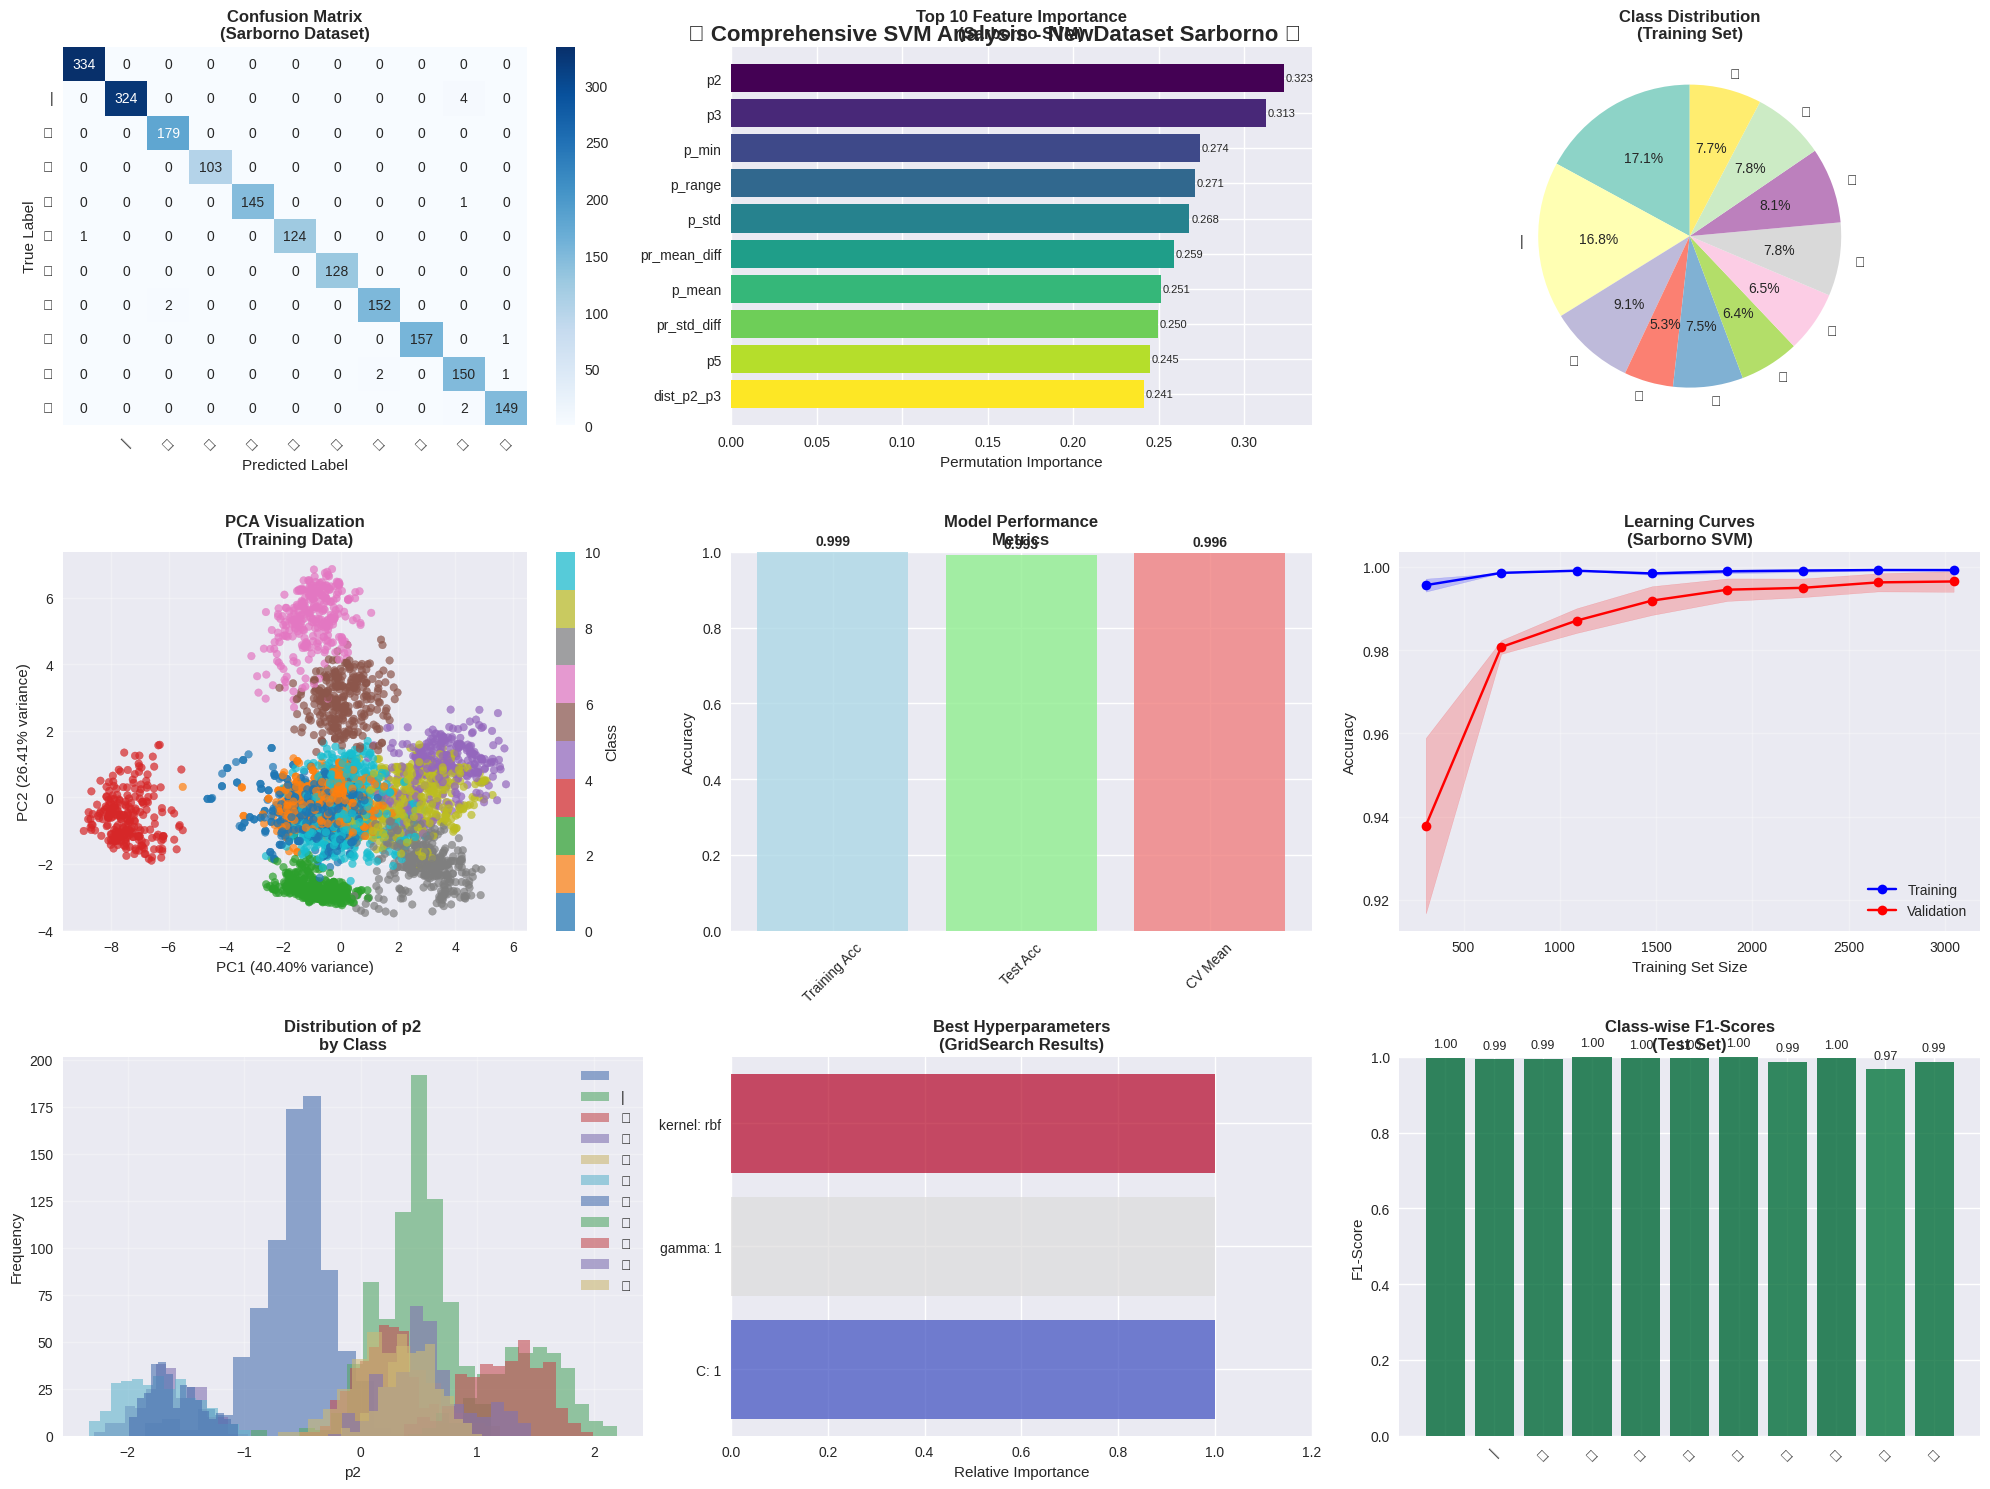


🎉 SVM MODEL ANALYSIS COMPLETE!
✅ Dataset: NewDataset Sarborno
✅ Model: Support Vector Machine (SVM)
✅ Best Kernel: rbf
✅ Test Accuracy: 0.9929 (99.29%)
✅ Classes Recognized: 11
✅ Total Features Used: 15
✅ Training Samples: 4569


In [8]:
# Comprehensive Visualizations for Sarborno SVM Model
if 'cm_sarborno' in locals() and 'importance_df_sarb' in locals():
    print("\n🎨 CREATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 45)
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # Create a comprehensive visualization dashboard
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    plt.subplot(3, 3, 1)
    sns.heatmap(cm_sarborno, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_class_names, yticklabels=test_class_names)
    plt.title('Confusion Matrix\n(Sarborno Dataset)', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 2. Feature Importance
    plt.subplot(3, 3, 2)
    top_features = importance_df_sarb.head(10)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Permutation Importance')
    plt.title('Top 10 Feature Importance\n(Sarborno SVM)', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    # 3. Class Distribution in Training Set
    plt.subplot(3, 3, 3)
    train_class_counts = pd.Series(y_train_sarb).value_counts().sort_index()
    train_class_labels = [label_encoder_sarborno.classes_[i] for i in train_class_counts.index]
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(train_class_labels)))
    plt.pie(train_class_counts.values, labels=train_class_labels, autopct='%1.1f%%',
            colors=colors_pie, startangle=90)
    plt.title('Class Distribution\n(Training Set)', fontsize=12, fontweight='bold')
    
    # 4. PCA Visualization
    plt.subplot(3, 3, 4)
    from sklearn.decomposition import PCA
    pca_sarb = PCA(n_components=2)
    X_pca_sarb = pca_sarb.fit_transform(X_train_selected_sarb)
    
    scatter = plt.scatter(X_pca_sarb[:, 0], X_pca_sarb[:, 1], c=y_train_sarb, 
                         cmap='tab10', alpha=0.7, s=30)
    plt.xlabel(f'PC1 ({pca_sarb.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_sarb.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA Visualization\n(Training Data)', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, label='Class')
    plt.grid(True, alpha=0.3)
    
    # 5. Model Performance Metrics
    plt.subplot(3, 3, 5)
    metrics = ['Training Acc', 'Test Acc', 'CV Mean']
    values = [train_accuracy_sarb, test_accuracy_sarb, cv_scores.mean()]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    bars = plt.bar(metrics, values, color=colors, alpha=0.8)
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Model Performance\nMetrics', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Learning Curve
    plt.subplot(3, 3, 6)
    from sklearn.model_selection import learning_curve
    
    # Calculate learning curve
    train_sizes_sarb, train_scores_sarb, val_scores_sarb = learning_curve(
        best_svm_sarborno, X_train_selected_sarb, y_train_sarb,
        cv=min(3, cv_folds), train_sizes=np.linspace(0.1, 1.0, 8), scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores_sarb, axis=1)
    train_std = np.std(train_scores_sarb, axis=1)
    val_mean = np.mean(val_scores_sarb, axis=1)
    val_std = np.std(val_scores_sarb, axis=1)
    
    plt.plot(train_sizes_sarb, train_mean, 'o-', color='blue', label='Training')
    plt.fill_between(train_sizes_sarb, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.plot(train_sizes_sarb, val_mean, 'o-', color='red', label='Validation')
    plt.fill_between(train_sizes_sarb, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves\n(Sarborno SVM)', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Feature Distribution (top 3 features)
    plt.subplot(3, 3, 7)
    if len(importance_df_sarb) >= 3:
        top_3_features = importance_df_sarb.head(3)['Feature'].tolist()
        feature_idx = [list(selected_feature_names).index(feat) for feat in top_3_features[:1]]  # Just show 1 for space
        
        if feature_idx:
            feat_name = top_3_features[0]
            feat_data = X_train_selected_sarb[:, feature_idx[0]]
            
            # Create histogram for each class
            for class_idx in np.unique(y_train_sarb):
                class_data = feat_data[y_train_sarb == class_idx]
                class_name = label_encoder_sarborno.classes_[class_idx]
                plt.hist(class_data, alpha=0.6, label=class_name, bins=15)
            
            plt.xlabel(feat_name)
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {feat_name}\nby Class', fontsize=12, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # 8. Hyperparameter Importance
    plt.subplot(3, 3, 8)
    best_params = grid_search.best_params_
    param_names = list(best_params.keys())
    param_values = [str(v) for v in best_params.values()]
    
    y_pos = np.arange(len(param_names))
    colors_param = plt.cm.coolwarm(np.linspace(0, 1, len(param_names)))
    plt.barh(y_pos, [1] * len(param_names), color=colors_param, alpha=0.7)
    plt.yticks(y_pos, [f'{name}: {val}' for name, val in zip(param_names, param_values)])
    plt.xlabel('Relative Importance')
    plt.title('Best Hyperparameters\n(GridSearch Results)', fontsize=12, fontweight='bold')
    plt.xlim(0, 1.2)
    
    # 9. Class-wise Performance
    plt.subplot(3, 3, 9)
    if 'class_report' in locals():
        class_f1_scores = []
        class_names_f1 = []
        for class_name in test_class_names:
            if class_name in class_report and isinstance(class_report[class_name], dict):
                class_f1_scores.append(class_report[class_name]['f1-score'])
                class_names_f1.append(class_name)
        
        if class_f1_scores:
            colors_f1 = plt.cm.RdYlGn(np.array(class_f1_scores))
            bars = plt.bar(range(len(class_f1_scores)), class_f1_scores, color=colors_f1, alpha=0.8)
            plt.xticks(range(len(class_names_f1)), class_names_f1, rotation=45)
            plt.ylabel('F1-Score')
            plt.title('Class-wise F1-Scores\n(Test Set)', fontsize=12, fontweight='bold')
            plt.ylim(0, 1)
            
            # Add value labels
            for bar, score in zip(bars, class_f1_scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{score:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.suptitle('🎯 Comprehensive SVM Analysis - NewDataset Sarborno 🎯', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Save the visualization
    output_path = '/home/meraj/Downloads/BdSL_Bangla Sign_Language/Sarborno_SVM_Analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"📊 Comprehensive visualization saved to: {output_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n🎉 SVM MODEL ANALYSIS COMPLETE!")
    print("=" * 40)
    print(f"✅ Dataset: NewDataset Sarborno")
    print(f"✅ Model: Support Vector Machine (SVM)")
    print(f"✅ Best Kernel: {best_svm_sarborno.kernel}")
    print(f"✅ Test Accuracy: {test_accuracy_sarb:.4f} ({test_accuracy_sarb*100:.2f}%)")
    print(f"✅ Classes Recognized: {len(test_class_names)}")
    print(f"✅ Total Features Used: {X_train_selected_sarb.shape[1]}")
    print(f"✅ Training Samples: {X_train_selected_sarb.shape[0]}")
    print("=" * 40)
    
else:
    print("❌ Required variables not available. Please run previous cells first.")